### Assumptions Prior to Using This Module 

1. To use "balanced" data set, please run Analyzer to generate the dataset first (it may take about 30 mins)
   - Example input: <project_dir>/loinc_predictor/data/andromeda-pond-hepatitis-c-balanced.csv
   
2. To use regular data (the sampled dataset from Andromeda), there's nothing you need to do.
   - Example input: <project_dir>/loinc_predictor/data/andromeda-pond-hepatitis-c.csv
   

In [1]:
import pandas as pd 
from pandas import DataFrame, Series
import os, sys, re
import numpy as np
from decimal import Decimal
from utils_sys import highlight

import warnings
warnings.filterwarnings('ignore')  # action='once'

# local modules
from analyzer import load_data, save_data, load_performance
import loinc as lc

%matplotlib inline

### Determine Target Cohort

In [2]:
cohort = 'hepatitis-c'

### Define Feature Set

In [3]:
"""
Memo
----
1. medivo_test_result_type is a function of the following attributes: 
      "meta_sender_name",
      "receiving_organization_id",
      "test_order_code",
      "test_order_name",
      "test_result_code",
      "test_result_name",
      "test_result_loinc_code",
      "test_result_units_of_measure"
      
"""
from analyzer import sample_col_values
from loinc import FeatureSet

cat_cols = FeatureSet.cat_cols  # 22 vars
cont_cols = FeatureSet.cont_cols  # e.g. age
derived_cols = FeatureSet.derived_cols
# ... ['count']  # other possible vars: test result n-th percentile, normalized test frequency

target_cols = FeatureSet.target_cols  # ['test_result_loinc_code', ]

# cardinality < 100
low_card_cols = FeatureSet.low_card_cols # ['patient_gender', 'fasting', 'meta_sender_name' ]
high_card_cols = FeatureSet.high_card_cols

target_columns = cat_cols + cont_cols + target_cols

### Load (Curated) Training Data

note: Training data was saved prior to the variable encoding

In [4]:
from analyzer import load_src_data, analyze_values

# input_file = f"andromeda-pond-{cohort}.csv" # or f"andromeda-pond-{cohort}-balanced.csv"
# ts = load_data(input_file=input_file, warn_bad_lines=False)
ts = load_src_data(cohort=cohort, warn_bad_lines=False, canonicalized=True, processed=True)

print("(load) dim(df): {} | columns:\n{}\n".format(ts.shape, 
        list(ts.columns.values[:10])+['...']+list(ts.columns.values[-10:]))) 
# ... 'ts' at this point contains all variables

# check feature values
analyze_values(ts, cols=cat_cols, topn=10)  # topn: most common n feature values (and their counts)

[load] Loading default input data: andromeda-pond-hepatitis-c-processed.csv
(canonicalize) Operations: fill n/a + dehyphenate + replace_values + trim_tail + fill others (non-target classes)
(load) dim(df): (71224, 127) | columns:
['meta_package_key', 'input_filename', 'patient_date_of_birth', 'patient_gender', 'patient_state', 'patient_bill_type', 'diagnosis_codes', 'diagnosis_descriptions', 'laboratory_diagnosis', 'billing_diagnosis_codes', '...', 'meta_dict_orig', 'meta_dict_final', 'meta_ingestion_datetime', 'meta_original_filename', 'meta_sender_name', 'meta_sender_source', 'meta_sender_type', 'meta_sender_dataset', 'meta_sender_ver', 'medivo_test_result_type']

[1] name: patient_gender => values: 
[('M', 42620), ('F', 28555), (nan, 49)]
 ... mode: M
[2] name: patient_state => values: 
[('CA', 9616), ('TX', 8828), ('FL', 7549), ('NY', 5827), ('PA', 4453), ('NJ', 3864), ('MD', 3269), ('GA', 1902), ('NC', 1675), ('TN', 1556)]
 ... mode: CA
[3] name: patient_bill_type => values: 
[('P

{'patient_gender': [('M', 42620), ('F', 28555), (nan, 49)],
 'patient_state': [('CA', 9616),
  ('TX', 8828),
  ('FL', 7549),
  ('NY', 5827),
  ('PA', 4453),
  ('NJ', 3864),
  ('MD', 3269),
  ('GA', 1902),
  ('NC', 1675),
  ('TN', 1556)],
 'patient_bill_type': [('PI', 18695),
  ('PRIVATE INSURANCE', 14270),
  ('CM', 10032),
  (nan, 8672),
  ('MC', 5098),
  ('MEDICARE', 4390),
  ('MEDICAID', 2668),
  ('MD', 2549),
  ('MANAGE CARE FFS', 2436),
  ('CLIENT', 1161)],
 'fasting': [(nan, 61446),
  ('NOT FASTING', 3942),
  ('Y', 1986),
  ('N', 1334),
  ('U', 1269),
  ('FASTING', 1247)],
 'performing_organization_id': [(nan, 29269),
  ('BN', 13666),
  ('RN', 5484),
  ('CPLSW', 4374),
  ('SO', 2292),
  ('CB', 2118),
  ('TA', 1973),
  ('MB', 1743),
  ('DA', 1267),
  ('PDLCA', 1227)],
 'receiving_organization_id': [(nan, 37380),
  ('CPLSW', 4374),
  ('22', 3660),
  ('28', 3054),
  ('17', 3024),
  ('1', 2727),
  ('15', 2360),
  ('35', 1579),
  ('30', 1529),
  ('41', 1370)],
 'test_result_status': [(

### Feature Transformation
note: patient_date_of_birth => age

In [5]:
from transformer import to_age
from analyzer import col_values
from loinc import FeatureSet

tTransformed = False

FeatureSet.to_age(ts)
values = col_values(ts, col='age', n=10)
print("> age: {}".format(values))

# datatime columns

> age: [71 61 69 72 59 71 69 68 62 69]


### Subset Variables, Encode Variables and Handling Missing Values

In [6]:
from analyzer import feature_transform

regular_vars, target_vars, derived_vars, meta_vars = FeatureSet.categorize_features(ts)
highlight("Found {} reg vars | {} label vars".format(len(regular_vars), len(target_vars)))
msg = ""
msg += "... regular_vars:  {}\n".format(regular_vars)
msg += "... target vars:   {}\n".format(target_vars)
msg += "... derived vars:  {}\n".format(derived_vars)
msg += "... meta_vars:     {}\n".format(meta_vars)
print(msg)

ts = feature_transform(ts, drop_high_missing=False, pth_null=0.9, verbose=1)

Found 23 reg vars | 1 label vars
... regular_vars:  ['patient_gender', 'patient_state', 'patient_bill_type', 'fasting', 'performing_organization_id', 'receiving_organization_id', 'test_result_status', 'test_order_code', 'test_order_name', 'test_result_code', 'test_result_name', 'test_result_value', 'test_result_range', 'test_result_abnormal_flag', 'test_result_reference_range', 'test_result_units_of_measure', 'test_result_comments', 'test_cpt_code', 'panel_order_code', 'panel_order_name', 'meta_sender_name', 'medivo_test_result_type', 'age']
... target vars:   ['test_result_loinc_code']
... derived vars:  []
... meta_vars:     []

[transform] age: [71 61 69 72 59 71 69 68 62 69]
(encoder_vars2) low card vars (n=['meta_sender_name', 'fasting', 'patient_gender']):
3
 ... high card vars (n=['test_result_status', 'performing_organization_id', 'test_order_name', 'test_result_reference_range', 'panel_order_code', 'test_result_comments', 'test_result_range', 'test_result_value', 'test_result_

### Partition Variables

In [7]:
from analyzer import encode_labels, summarize_dict, get_sample_sizes
import collections, operator

codebook={'pos': 1, 'neg': 0, '+': 1, '-': 0}

tsX, tsY, ts_derived, ts_meta = FeatureSet.partition(ts)

print("> Found n(X)={}, n(Y)={}, n(Derived)={}, n(Meta):{}".format(
    tsX.shape[1], tsY.shape[1], ts_derived.shape[1], ts_meta.shape[1]))

# verify
assert tsX.shape[0] == tsY.shape[0]

[partition] 203 reg vars | 1 label vars
... regular_vars (X): ['patient_gender_1', 'patient_gender_2', 'patient_gender_3', 'patient_state_0', 'patient_state_1', 'patient_state_2', 'patient_state_3', 'patient_state_4', 'patient_state_5', 'patient_state_6', 'patient_bill_type_0', 'patient_bill_type_1', 'patient_bill_type_2', 'patient_bill_type_3', 'patient_bill_type_4', 'fasting_1', 'fasting_2', 'fasting_3', 'fasting_4', 'fasting_5', 'fasting_6', 'performing_organization_id_0', 'performing_organization_id_1', 'performing_organization_id_2', 'performing_organization_id_3', 'performing_organization_id_4', 'performing_organization_id_5', 'performing_organization_id_6', 'performing_organization_id_7', 'performing_organization_id_8', 'receiving_organization_id_0', 'receiving_organization_id_1', 'receiving_organization_id_2', 'receiving_organization_id_3', 'receiving_organization_id_4', 'receiving_organization_id_5', 'receiving_organization_id_6', 'test_result_status_0', 'test_result_status_1'

### Model Training

In [8]:
import utils_tree, utils_sys, analyzer
import collections
from analyzer import balance_by_downsampling
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from loinc import TSet, FeatureSet, LoincTSet
from common import apply_scaling

def get_sample_size(y, code_book={}):
    if not code_book: code_book = TSet.codebook
    counter = collections.Counter(y)
    return (counter[codebook['neg']], counter[codebook['pos']])

# model training parameters 
n_fold = 5
n_min = n_fold  # min number of examples to train a classifier
scaling_method = 'minmax'
tBalance = True   # balance the data set? If True, will attempt to limit the sample size of the majority class

# data transformation
col_target = LoincTSet.col_target  # 'test_result_loinc_name'
# regular_vars, target_vars, derived_vars, meta_vars = FeatureSet.categorize_features(ts)

# subsampling parameters 
majority_max = 10    # majority class is only allowed to have at most this multiple of samples than the minority class
sampling_method = 'multiple'

X, y = tsX.values, tsY.values.flatten()
loinc_set = raw_labels = np.unique(y)
print("> dim(X): {}, sample(y): {}".format(X.shape, np.random.choice(loinc_set,20) ))

# feature scaling
X = apply_scaling(X, scaler=scaling_method)

# attributes for performance data
header = ['code', 'mean', 'std', 'n_pos', 'total']
sdict = {h:[] for h in header}
for code in loinc_set: 
    y_bin = analyzer.encode_labels(y, pos_label=code)
    
    n_neg0, n_pos0 = get_sample_size(y_bin)
    
    if n_pos0 >= n_min: # if n(pos) is above a min threshold, then train a model
        
        # we could have done subsampling here but then the else case wouldn't get a corret
        if tBalance: 
            X_eff, y_eff = balance_by_downsampling(X, y_bin, method=sampling_method, majority_max=majority_max)
            assert isinstance(y_eff, np.ndarray) and isinstance(X_eff, np.ndarray)
        else: 
            X_eff, y_eff = X, y_bin
        
        n_neg, n_pos = get_sample_size(y_eff)
        
        # training + evaluation (default classifier: logistic regression)
        scores = analyzer.eval_performance(X_eff, y_eff, model=None, cv=n_fold, random_state=53, verbose=1)
        # metric: f1 score
        
        mean_score = np.mean(scores)
        std_score = np.std(scores)
        print("... average Fmax: {}, std: {}".format(mean_score, std_score))
    else: 
        print("> (positive) sample size too small, n={}".format(n_pos0))
        mean_score = -1 
        std_score = -1
        
        # hypothetical sample sizes if one were to train this classifier
        n_neg = min(n_pos0, n_neg0) * majority_max
        n_pos = n_pos0
        
    print(f"... Code: {code} | sample size | n0(-): {n_neg0}, n0(+): {n_pos0} ->(subsample)-> n(-): {n_neg}, n(+): {n_pos}")
        
    sdict['code'].append(code)
    sdict['mean'].append(mean_score)
    sdict['std'].append(std_score)
    sdict['n_pos'].append(n_pos)
    sdict['total'].append(n_pos+n_neg)

# --------------------------------------------------
# save performance dataframe
df_perf = DataFrame(sdict, columns=header)
df_perf = df_perf.sort_values(by=['mean', ]) # ascending=False
analyzer.save_performance(df_perf, output_dir='result', cohort=cohort, verbose=1)  # other opts: output_file
# ... default sep: '|' but NOT ',' 


> dim(X): (71224, 203), sample(y): ['505578' '20644' '594192' '160119' '112771' '327767' '39347' '56853'
 '30247' '7989' '56853' '204057' '33498' '452243' '509570' '490243'
 '505537' '178566' '110908' '178616']
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 005025 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 10058 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 103317 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 103341 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71209, 1:

> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9743309244788129 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9818574179693748 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.979246372505071 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9803375846263329 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9630563789251084 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 111567 | sample size | n0(-): 71219, n0(+): 5 ->(subsample)-> n(-): 50, n(+): 5
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 112532 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71050, 1: 174})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9818684794320471 | F1: 0.9859154929577464, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.43044032404070515 | F1: 0.97

> Fmax: 0.9960159362549801 p_th: 0.7910104130702704 | F1: 0.9960159362549801, AUC: 0.9999935794542537
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9652515903599319 | F1: 0.9960159362549801, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9032734169831249 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9672827521496188 | F1: 0.9959839357429718, AUC: 1.0
... average Fmax: 0.998406374501992, std: 0.0019517846556041242
... Code: 134577 | sample size | n0(-): 70601, n0(+): 623 ->(subsample)-> n(-): 6230, n(+): 623
(encode_labels) sample size: Counter({0: 70885, 1: 339})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.11152997182186153 | F1: 0.9850746268656716, AUC: 1.0
> 1 of KFold 5
> Fmax: 0.9925925925925926 p_th: 0.3270751870014425 | F1: 0.9774436090225563, AUC: 0.9998264792642721
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9890127258840188 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th

... Code: 141358 | sample size | n0(-): 71192, n0(+): 32 ->(subsample)-> n(-): 320, n(+): 32
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 142364 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71185, 1: 39})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9877204550868194 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9688350262736517 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9785640021746681 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9838495051214116 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9948043905848172 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 142513 | sample size | n0(-): 71185, n0(+): 39 ->(subsample)-> n(-): 390, n(+): 39
(encode_labels) sample size: Counter({0: 71223, 1: 1})

(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 154120 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 154328 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 155465 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71219, 1: 5})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9380267704363595 | F1: 0.6666666666666666, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.7265359594565098 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.7398107171677146 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th:

> Fmax: 0.997920997920998 p_th: 0.7645908237738226 | F1: 0.997920997920998, AUC: 0.9999917877256754
> 2 of KFold 5
> Fmax: 0.9989615784008308 p_th: 0.9452257326254133 | F1: 0.9979253112033196, AUC: 0.9999991355500711
> 3 of KFold 5
> Fmax: 0.9958506224066389 p_th: 0.24882259238017057 | F1: 0.9948078920041536, AUC: 0.9999377596051192
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.8196513349038026 | F1: 1.0, AUC: 1.0
... average Fmax: 0.9981317019863575, std: 0.0013761940080214488
... Code: 17426 | sample size | n0(-): 68819, n0(+): 2405 ->(subsample)-> n(-): 24050, n(+): 2405
(encode_labels) sample size: Counter({0: 71222, 1: 2})
> (positive) sample size too small, n=2
... Code: 174334 | sample size | n0(-): 71222, n0(+): 2 ->(subsample)-> n(-): 20, n(+): 2
(encode_labels) sample size: Counter({0: 70945, 1: 279})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9822543422321671 | F1: 0.9

... Code: 18093 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71218, 1: 6})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9815502120204824 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9875603139911642 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9860713284070254 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9797182429664374 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9762024083356028 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 181826 | sample size | n0(-): 71218, n0(+): 6 ->(subsample)-> n(-): 60, n(+): 6
(encode_labels) sample size: Counter({0: 71185, 1: 39})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.3353325204827007 | F1: 0.9333

> Fmax: 1.0 p_th: 0.8859965751995611 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9390442680038619 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 0.9987325728770595 p_th: 0.9660577918148855 | F1: 0.9936948297604036, AUC: 0.9999864790734689
> 4 of KFold 5
> Fmax: 0.9987325728770595 p_th: 0.8110300567964339 | F1: 0.9962073324905183, AUC: 0.9999929176099123
... average Fmax: 0.9994930291508238, std: 0.0006209099474735794
... Code: 19208 | sample size | n0(-): 69253, n0(+): 1971 ->(subsample)-> n(-): 19710, n(+): 1971
(encode_labels) sample size: Counter({0: 71219, 1: 5})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9730595475611399 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9780624436549329 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9684816991936172 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9859231247372133 | F1: 1.0, AUC: 1.0
> 4 

(encode_labels) sample size: Counter({0: 70810, 1: 414})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9291218499003924 | F1: 0.9940119760479043, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.7182818602660253 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9349449147925412 | F1: 0.988095238095238, AUC: 1.0
> 3 of KFold 5
> Fmax: 0.993939393939394 p_th: 0.9730664929395358 | F1: 0.993939393939394, AUC: 0.999941796170188
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9758564476811934 | F1: 1.0, AUC: 1.0
... average Fmax: 0.9987878787878788, std: 0.0024242424242423956
... Code: 19687 | sample size | n0(-): 70810, n0(+): 414 ->(subsample)-> n(-): 4140, n(+): 414
(encode_labels) sample size: Counter({0: 71083, 1: 141})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.897945

> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9460936293737421 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9814647401635218 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 20396 | sample size | n0(-): 71196, n0(+): 28 ->(subsample)-> n(-): 280, n(+): 28
(encode_labels) sample size: Counter({0: 71216, 1: 8})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9877333797345897 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.8363038987043945 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9854825434099624 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.938315577636564 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.5042601050925934 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 204057 | sample size | n0(-): 71216, n0(+): 8 ->(subsample)-> n(-): 80, n(+): 8
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) s

> Fmax: 1.0 p_th: 0.9363716438701667 | F1: 0.9523809523809523, AUC: 1.0
> 4 of KFold 5
> Fmax: 0.975609756097561 p_th: 0.9328623021130085 | F1: 0.975609756097561, AUC: 0.9992574257425743
... average Fmax: 0.9951219512195122, std: 0.009756097560975618
... Code: 205708 | sample size | n0(-): 71123, n0(+): 101 ->(subsample)-> n(-): 1010, n(+): 101
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 206060 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71221, 1: 3})
> (positive) sample size too small, n=3
... Code: 206243 | sample size | n0(-): 71221, n0(+): 3 ->(subsample)-> n(-): 30, n(+): 3
(encode_labels) sample size: Counter({0: 71216, 1: 8})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9574875671836244 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_

> Fmax: 1.0 p_th: 0.934681475259637 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9098153698707547 | F1: 0.9795918367346939, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.5206342644264718 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9705861907084383 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.8882193021446267 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 21618 | sample size | n0(-): 71105, n0(+): 119 ->(subsample)-> n(-): 1190, n(+): 119
(encode_labels) sample size: Counter({0: 71222, 1: 2})
> (positive) sample size too small, n=2
... Code: 21626 | sample size | n0(-): 71222, n0(+): 2 ->(subsample)-> n(-): 20, n(+): 2
(encode_labels) sample size: Counter({0: 71222, 1: 2})
> (positive) sample size too small, n=2
... Code: 21642 | sample size | n0(-): 71222, n0(+): 2 ->(subsample)-> n(-): 20, n(+): 2
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 216960 | sample size | n0(-): 71223, n0(+

(encode_labels) sample size: Counter({0: 71055, 1: 169})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 0.9855072463768115 p_th: 0.9311479926177504 | F1: 0.9714285714285714, AUC: 0.9999129829446571
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.674718561131024 | F1: 0.9855072463768115, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9526244990176452 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9004471438383237 | F1: 0.9855072463768115, AUC: 1.0
> 4 of KFold 5
> Fmax: 0.9850746268656716 p_th: 0.3318039616470927 | F1: 0.9696969696969697, AUC: 0.9999103460641922
... average Fmax: 0.9941163746484966, std: 0.007207238505795524
... Code: 23457 | sample size | n0(-): 71055, n0(+): 169 ->(subsample)-> n(-): 1690, n(+): 169
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 236562 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n

> Fmax: 1.0 p_th: 0.8315105272560291 | F1: 0.9850746268656716, AUC: 1.0
... average Fmax: 0.9971014492753623, std: 0.0057971014492753875
... Code: 24984 | sample size | n0(-): 71056, n0(+): 168 ->(subsample)-> n(-): 1680, n(+): 168
(encode_labels) sample size: Counter({0: 71097, 1: 127})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.8533131008556516 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 0.9811320754716981 p_th: 0.4827335008827676 | F1: 0.9615384615384616, AUC: 0.9998485766202302
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9776482830422744 | F1: 0.9803921568627451, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9346336989935883 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.8413092480823222 | F1: 1.0, AUC: 1.0
... average Fmax: 0.9962264150943396, std: 0.007547169811320752
... Code: 25007 | sample size | n0(-): 71097, n0(+): 127 ->(subsample)-> n(-): 1270, n(+): 127
(enco

> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9835312477482387 | F1: 0.9818181818181818, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9497802644952872 | F1: 0.9818181818181818, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 264507 | sample size | n0(-): 71088, n0(+): 136 ->(subsample)-> n(-): 1360, n(+): 136
(encode_labels) sample size: Counter({0: 71116, 1: 108})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9544753061578019 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9925569932067423 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9584707323329739 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.966670667807178 | F1: 0.9767441860465117, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9208349434267264 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 264531 | sample size | n0(-): 71116, n0(+): 108 ->(subsample)-> n(-): 1080, n(+): 108
(encode_labe

> Fmax: 1.0 p_th: 0.9222427487453808 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9716594124817538 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9966492818383221 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 265157 | sample size | n0(-): 71143, n0(+): 81 ->(subsample)-> n(-): 810, n(+): 81
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 265231 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 265249 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71222, 1: 2})
> (positive) sample size too small, n=2
... Code: 268748 | sample size | n0(-): 71222, n0(+): 2 ->(subsample)-> n(-): 20, n(+): 2
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 26971 | sample

> Fmax: 1.0 p_th: 0.821814257625678 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.963883702501102 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.3000331331027846 | F1: 0.6666666666666666, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9628466215876427 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9411783331377768 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 28654 | sample size | n0(-): 71213, n0(+): 11 ->(subsample)-> n(-): 110, n(+): 11
(encode_labels) sample size: Counter({0: 71209, 1: 15})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9241056447155125 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9258813002126476 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.8444859316009887 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.4657998857052151 | F1: 0.8, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.972976016248

> Fmax: 1.0 p_th: 0.377162166021567 | F1: 0.8750000000000001, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.8635646698505043 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9669778487807197 | F1: 0.9411764705882353, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9681088137915316 | F1: 0.9411764705882353, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 29868 | sample size | n0(-): 71182, n0(+): 42 ->(subsample)-> n(-): 420, n(+): 42
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 298927 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71222, 1: 2})
> (positive) sample size too small, n=2
... Code: 298935 | sample size | n0(-): 71222, n0(+): 2 ->(subsample)-> n(-): 20, n(+): 2
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 29900 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(enco

(encode_labels) sample size: Counter({0: 71203, 1: 21})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9937135850906432 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9842728575878749 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9612506469551804 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 0.888888888888889 p_th: 0.05926805530139911 | F1: 0.8571428571428571, AUC: 0.9940476190476191
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9607936584442015 | F1: 1.0, AUC: 1.0
... average Fmax: 0.9777777777777779, std: 0.04444444444444442
... Code: 303768 | sample size | n0(-): 71203, n0(+): 21 ->(subsample)-> n(-): 210, n(+): 21
(encode_labels) sample size: Counter({0: 71126, 1: 98})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.947499745735555 | F1: 1.0, AUC: 1.0
> 

(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9452156439328236 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9148647737965249 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9571863467700631 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9636867228833355 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.8813538038032139 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 30841 | sample size | n0(-): 71163, n0(+): 61 ->(subsample)-> n(-): 610, n(+): 61
(encode_labels) sample size: Counter({0: 71139, 1: 85})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9783316049820528 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9841369095985913 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.33523730570891536 | F1: 0.9

... Code: 31815 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 320184 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71221, 1: 3})
> (positive) sample size too small, n=3
... Code: 322156 | sample size | n0(-): 71221, n0(+): 3 ->(subsample)-> n(-): 30, n(+): 3
(encode_labels) sample size: Counter({0: 70410, 1: 814})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 0.9878048780487805 p_th: 0.9067390268662735 | F1: 0.9760479041916168, AUC: 0.9994724227853062
> 1 of KFold 5
> Fmax: 0.9938271604938271 p_th: 0.952869592873822 | F1: 0.9848024316109423, AUC: 0.9999736211392652
> 2 of KFold 5
> Fmax: 0.9969418960244648 p_th: 0.9156047943707245 | F1: 0.9819277108433735, AUC: 0.9999924631826472
> 3 of 

... average Fmax: 1.0, std: 0.0
... Code: 333583 | sample size | n0(-): 71215, n0(+): 9 ->(subsample)-> n(-): 90, n(+): 9
(encode_labels) sample size: Counter({0: 71221, 1: 3})
> (positive) sample size too small, n=3
... Code: 33498 | sample size | n0(-): 71221, n0(+): 3 ->(subsample)-> n(-): 30, n(+): 3
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 336677 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 33894 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 33902 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 339101 | sample size | n0(-): 71223,

... Code: 381806 | sample size | n0(-): 70175, n0(+): 1049 ->(subsample)-> n(-): 10490, n(+): 1049
(encode_labels) sample size: Counter({0: 71210, 1: 14})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9918687519027036 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9846847504089229 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9884432618152579 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9866868323175447 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9879518972627238 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 382507 | sample size | n0(-): 71210, n0(+): 14 ->(subsample)-> n(-): 140, n(+): 14
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 384453 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71215, 

> Fmax: 0.9722222222222222 p_th: 0.9587110168619264 | F1: 0.9589041095890412, AUC: 0.9980170387779084
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9887071639557766 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.8200024502900877 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 0.9866666666666666 p_th: 0.8302587122094013 | F1: 0.9866666666666666, AUC: 0.9999265569917745
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9718609724404146 | F1: 0.9863013698630138, AUC: 1.0
... average Fmax: 0.9917777777777778, std: 0.011057649159666437
... Code: 433961 | sample size | n0(-): 71040, n0(+): 184 ->(subsample)-> n(-): 1840, n(+): 184
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 437277 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 448134 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) samp

(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 461277 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71221, 1: 3})
> (positive) sample size too small, n=3
... Code: 461285 | sample size | n0(-): 71221, n0(+): 3 ->(subsample)-> n(-): 30, n(+): 3
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 461541 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71220, 1: 4})
> (positive) sample size too small, n=4
... Code: 462168 | sample size | n0(-): 71220, n0(+): 4 ->(subsample)-> n(-): 40, n(+): 4
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 462176 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71221, 1: 3})
> (positive) sample 

... average Fmax: 0.9981481084556855, std: 0.002268135181861232
... Code: 487959 | sample size | n0(-): 70682, n0(+): 542 ->(subsample)-> n(-): 5420, n(+): 542
(encode_labels) sample size: Counter({0: 71218, 1: 6})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.8581164865536419 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9847620604451803 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9801062953953439 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.5794637408991381 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9923301617098331 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 487967 | sample size | n0(-): 71218, n0(+): 6 ->(subsample)-> n(-): 60, n(+): 6
(encode_labels) sample size: Counter({0: 71220, 1: 4})
> (positive) sample size too small, n=4
... Code: 490243 | sample size | n0(-): 71220, n0(+): 4 ->(subsample)-> n(-): 40,

(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 514372 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71220, 1: 4})
> (positive) sample size too small, n=4
... Code: 514786 | sample size | n0(-): 71220, n0(+): 4 ->(subsample)-> n(-): 40, n(+): 4
(encode_labels) sample size: Counter({0: 71220, 1: 4})
> (positive) sample size too small, n=4
... Code: 514802 | sample size | n0(-): 71220, n0(+): 4 ->(subsample)-> n(-): 40, n(+): 4
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 514869 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71220, 1: 4})
> (positive) sample size too small, n=4
... Code: 514877 | sample size | n0(-): 71220, n0(+): 4 ->(subsample)-> n(-): 40, n(+): 4
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample 

... Code: 53728 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71190, 1: 34})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.812883654406827 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9657026842285161 | F1: 0.9333333333333333, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.8900062390779714 | F1: 0.9333333333333333, AUC: 1.0
> 3 of KFold 5
> Fmax: 0.9333333333333333 p_th: 0.6996184539992547 | F1: 0.9333333333333333, AUC: 0.9936974789915967
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9600553734033168 | F1: 0.923076923076923, AUC: 1.0
... average Fmax: 0.9866666666666667, std: 0.02666666666666666
... Code: 539627 | sample size | n0(-): 71190, n0(+): 34 ->(subsample)-> n(-): 340, n(+): 34
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 54031 | sample size

(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.48091153793104713 | F1: 0.8, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9556528854580303 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9384406318514682 | F1: 0.8571428571428571, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.957802203198194 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.989964168625531 | F1: 0.8571428571428571, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 57976 | sample size | n0(-): 71209, n0(+): 15 ->(subsample)-> n(-): 150, n(+): 15
(encode_labels) sample size: Counter({0: 71205, 1: 19})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.8111197632479608 | F1: 0.888888888888889, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9777870516067496 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fm

(encode_labels) sample size: Counter({0: 71204, 1: 20})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9914555294906395 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 0.8571428571428571 p_th: 0.9869822817220718 | F1: 0.8571428571428571, AUC: 0.9874999999999999
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.4531863349779434 | F1: 0.8571428571428571, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.993043391748549 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9925177521655181 | F1: 1.0, AUC: 1.0
... average Fmax: 0.9714285714285715, std: 0.05714285714285716
... Code: 602797 | sample size | n0(-): 71204, n0(+): 20 ->(subsample)-> n(-): 200, n(+): 20
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 60756 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (

> Fmax: 1.0 p_th: 0.8483790245073429 | F1: 0.9985935302390998, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.83086323291322 | F1: 0.9985935302390998, AUC: 1.0
> 2 of KFold 5
> Fmax: 0.9985935302390998 p_th: 0.817389100637057 | F1: 0.9957924263674615, AUC: 0.9999976195199365
> 3 of KFold 5
> Fmax: 0.9985935302390998 p_th: 0.7185971477671154 | F1: 0.9971910112359551, AUC: 0.9999992065066454
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.8897238591441796 | F1: 0.9971910112359551, AUC: 1.0
... average Fmax: 0.99943741209564, std: 0.0006890266505719486
... Code: 66902 | sample size | n0(-): 69449, n0(+): 1775 ->(subsample)-> n(-): 17750, n(+): 1775
(encode_labels) sample size: Counter({0: 71219, 1: 5})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9780737244610077 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9827873584188886 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9

> Fmax: 1.0 p_th: 0.2535593658049667 | F1: 0.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 7146 | sample size | n0(-): 71215, n0(+): 9 ->(subsample)-> n(-): 90, n(+): 9
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 71555 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71218, 1: 6})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9741444511078333 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9827851481689257 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9894473199073761 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9894704351606562 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9871170800254668 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 716951 | sample size | n0(-): 71218, n0(+): 6 ->(subsam

(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9374142138620777 | F1: 0.9974554707379135, AUC: 1.0
> 1 of KFold 5
> Fmax: 0.9974554707379135 p_th: 0.3165694168630508 | F1: 0.9974424552429668, AUC: 0.9999973915946747
> 2 of KFold 5
> Fmax: 0.9974424552429668 p_th: 0.9580623394492971 | F1: 0.9923664122137404, AUC: 0.999984349568048
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.8249469244166633 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.7771259147187517 | F1: 1.0, AUC: 1.0
... average Fmax: 0.998979585196176, std: 0.001249754575148826
... Code: 7369 | sample size | n0(-): 70246, n0(+): 978 ->(subsample)-> n(-): 9780, n(+): 978
(encode_labels) sample size: Counter({0: 71221, 1: 3})
> (positive) sample size too small, n=3
... Code: 7377 | sample size | n0(-): 71221, n0(+): 3 ->(subsample)-> n(-): 30, n(+): 3
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) s

(encode_labels) sample size: Counter({0: 71221, 1: 3})
> (positive) sample size too small, n=3
... Code: 7690 | sample size | n0(-): 71221, n0(+): 3 ->(subsample)-> n(-): 30, n(+): 3
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 76919 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 69860, 1: 1364})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9073520016440595 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9132044429792091 | F1: 0.9963503649635036, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9765217865949452 | F1: 0.9963503649635036, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.8888160828626097 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 0.998165137614679 p_th: 0.6548083599972712 | F1: 0.998165137614679, AUC: 0.9999986523201656
... average Fma

... Code: 7880 | sample size | n0(-): 71178, n0(+): 46 ->(subsample)-> n(-): 460, n(+): 46
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 78857 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 70733, 1: 491})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9284989768422751 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9492078617906217 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9680935731914637 | F1: 0.9949238578680203, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9255737651076937 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9452363371649466 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 7898 | sample size | n0(-): 70733, n0(+): 491 ->(subsample)-> n(-): 4910, n(+): 491
(encode_labels) sample size: Counter({0:

... Code: 82362 | sample size | n0(-): 71221, n0(+): 3 ->(subsample)-> n(-): 30, n(+): 3
(encode_labels) sample size: Counter({0: 71222, 1: 2})
> (positive) sample size too small, n=2
... Code: 823765 | sample size | n0(-): 71222, n0(+): 2 ->(subsample)-> n(-): 20, n(+): 2
(encode_labels) sample size: Counter({0: 71219, 1: 5})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9831828294351235 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9796690597718817 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9796397530261396 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.98318437899091 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.6426835493891339 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 823773 | sample size | n0(-): 71219, n0(+): 5 ->(subsample)-> n(-): 50, n(+): 5
(encode_labels) sample size: Counter({0: 71218, 1: 6})
(balance_

> Fmax: 1.0 p_th: 0.977408523680572 | F1: 0.9753086419753086, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 882944 | sample size | n0(-): 70825, n0(+): 399 ->(subsample)-> n(-): 3990, n(+): 399
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 884478 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 884486 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 885178 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 908947 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71150, 1: 74})
(bala

[7385] -> -1.0
[7377] -> -1.0
[736546] -> -1.0
[7351] -> -1.0
[724864] -> -1.0
[717744] -> -1.0
[71555] -> -1.0
[71001] -> -1.0
[7021] -> -1.0
[701417] -> -1.0
[690487] -> -1.0
[68965] -> -1.0
[68338] -> -1.0
[744441] -> -1.0
[67702] -> -1.0
[80614] -> -1.0
[80937] -> -1.0
[98426] -> -1.0
[97287] -> -1.0
[96644] -> -1.0
[96610] -> -1.0
[96107] -> -1.0
[95976] -> -1.0
[95927] -> -1.0
[908947] -> -1.0
[885178] -> -1.0
[884486] -> -1.0
[884478] -> -1.0
[882934] -> -1.0
[82537] -> -1.0
[825232] -> -1.0
[80689] -> -1.0
[825216] -> -1.0
[823807] -> -1.0
[823765] -> -1.0
[82362] -> -1.0
[82206] -> -1.0
[82198] -> -1.0
[81729] -> -1.0
[81380] -> -1.0
[81372] -> -1.0
[81299] -> -1.0
[81174] -> -1.0
[81166] -> -1.0
[81125] -> -1.0
[80994] -> -1.0
[80945] -> -1.0
[825141] -> -1.0
[661496] -> -1.0
[64717] -> -1.0
[64204] -> -1.0
[56432] -> -1.0
[56390] -> -1.0
[557520] -> -1.0
[551598] -> -1.0
[550513] -> -1.0
[54031] -> -1.0
[53728] -> -1.0
[53587] -> -1.0
[533265] -> -1.0
[533182] -> -1.0
[53316

[134999] -> 1.0
[771477] -> 1.0
[772020] -> 1.0
[7732] -> 1.0
[7765] -> 1.0
[7831] -> 1.0
[7856] -> 1.0
[7872] -> 1.0
[112821] -> 1.0
[7880] -> 1.0
[79053] -> 1.0
[28621] -> 1.0
[128512] -> 1.0
[128413] -> 1.0
[254284] -> 1.0
[285403] -> 1.0
[121855] -> 1.0
[285395] -> 1.0
[115790] -> 1.0
[81018] -> 1.0
[115725] -> 1.0
[81224] -> 1.0
[7898] -> 1.0
[7864] -> 1.0
[303925] -> 1.0
[64634] -> 1.0
[195586] -> 1.0
[195503] -> 1.0
[473835] -> 1.0
[345355] -> 1.0
[486431] -> 1.0
[192955] -> 1.0
[487967] -> 1.0
[20958] -> 1.0
[192708] -> 1.0
[192526] -> 1.0
[495416] -> 1.0
[497818] -> 1.0
[339358] -> 1.0
[50484] -> 1.0
[505511] -> 1.0
[21329] -> 1.0
[21576] -> 1.0
[333583] -> 1.0
[21618] -> 1.0
[330373] -> 1.0
[264747] -> 1.0
[18341] -> 1.0
[183145] -> 1.0
[32896] -> 1.0
[327767] -> 1.0
[18259] -> 1.0
[181826] -> 1.0
[347047] -> 1.0
[349993] -> 1.0
[460980] -> 1.0
[196444] -> 1.0
[204552] -> 1.0
[204545] -> 1.0
[204537] -> 1.0
[397786] -> 1.0
[204164] -> 1.0
[204081] -> 1.0
[382507] -> 1.0
[2040

### Visualize Results

> dim(performance matrix): (733, 5)
> dim(performance matrix): (733, 5)
> dim(performance matrix): (733, 5)
(label_by_performance) dim(df_perf): (733, 5)
1. Total number of codes: 733 | n(low_sample): 422(57.572%), n(scored):311(42.428%), n(high scored):309(42.156%)
2. Pecentage scored codes: 42.428%
3. Percentage "good" codes: 42.156%
[analysis] N(codes; cohort=hepatitis-c): 733
...        n(easy): 309 | ratio: 0.42155525238744884
...        n(hard): 2 | ratio: 0.002728512960436562
...        n(low):  422 | ratio: 0.5757162346521146
1. Total number of codes: 733 | n(low_sample): 422, n(scored):311, n(high scored):309
2. Fraction of scored codes: 0.4242837653478854
3. Fraction of highly scored codes: 0.42155525238744884
       code      mean       std  n_pos  total
0     81240  1.000000  0.000000      8     88
14   505511  1.000000  0.000000      6     66
24   203927  1.000000  0.000000     41    451
23   327692  1.000000  0.000000      5     55
22   426171  1.000000  0.000000      6  

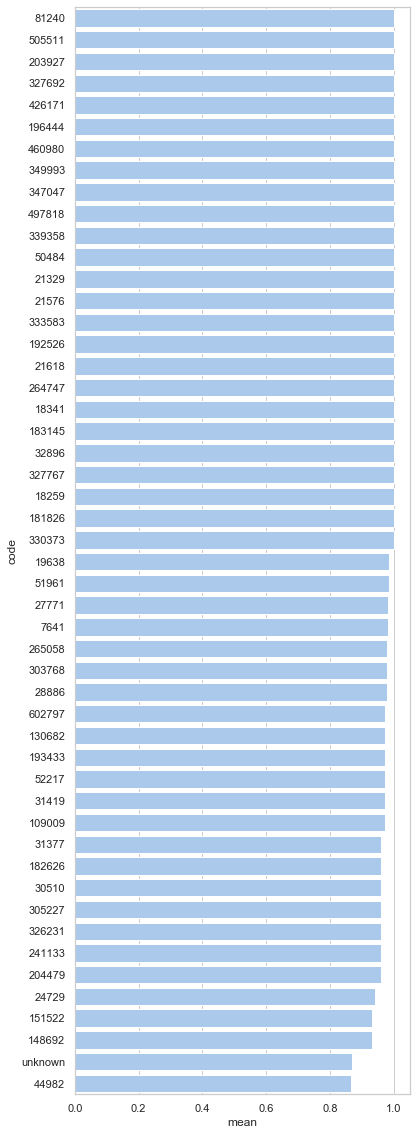

In [9]:
"""

Memo
---- 
1. performance plot

   perplot: https://pypi.org/project/perfplot/
"""
import seaborn as sns
import matplotlib.pyplot as plt
from analyzer import load_performance, label_by_performance
from utils_sys import size_hashtable

sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 20))
sns.set_color_codes("pastel")

#---------------------------------------------

# load performance data
cohort = 'hepatitis-c'
df_perf = load_performance(input_dir='result', cohort=cohort)
print("> dim(performance matrix): {}".format(df_perf.shape))

# sort ~ performance scores 
# df_perf = df_perf.sort_values(by=['mean', ], ascending=False)

categories = ['easy', 'hard', 'low']
ccmap = label_by_performance(cohort=cohort, categories=categories)
N = size_hashtable(ccmap)
N_easy = len(ccmap['easy'])
N_hard = len(ccmap['hard'])
N_low = len(ccmap['low'])
print("[analysis] N(codes; cohort={}): {}".format(cohort, N))
print("...        n(easy): {} | ratio: {}".format(N_easy, N_easy/(N+0.0)))
print("...        n(hard): {} | ratio: {}".format(N_hard, N_hard/(N+0.0)))
print("...        n(low):  {} | ratio: {}".format(N_low,  N_low/(N+0.0)))

header = ['code', 'mean', 'std', 'n_pos']
codes = df_perf['code']
n_codes = len(codes)
scores = df_perf['mean']

# some statistics
score_high = 0.90
score_low = 0.50

codes_low_sz = ccmap['low']
codes_scored = np.hstack( [ccmap['easy'], ccmap['hard']] )
codes_high_score = ccmap['easy']
assert n_codes == len(codes_low_sz) + len(codes_scored)

print("1. Total number of codes: {} | n(low_sample): {}, n(scored):{}, n(high scored):{}".format(n_codes, 
   len(codes_low_sz), len(codes_scored), len(codes_high_score)))

r_scored = len(codes_scored)/(n_codes+0.0)
rh = len(codes_high_score)/(n_codes+0.0)
print("2. Fraction of scored codes: {}".format(r_scored))
print("3. Fraction of highly scored codes: {}".format(rh))

# Effective performance dataframe, ruling out those codes without scores (due to low sample sizes)
df_eff = df_perf.loc[df_perf['mean'] >= 0.0]

n_offset = 25
df_topn = df_eff.sort_values(['mean', ], ascending=False).head(n_offset)
df_botn = df_eff.sort_values(['mean', ], ascending=True).head(n_offset)
# print(df_botn)

# codes = [str(c) for c in df_botn['code'].values]
# print('lower codes: {}'.format(codes))
# scores = df_botn['mean'].values
# print('scores: {}'.format(scores))

# top n + bottom n
dfe = pd.concat([df_topn, df_botn], ignore_index=True)
dfe.sort_values(by=['mean', ], ascending=False, inplace=True)
codes = [str(c) for c in dfe['code'].values]
scores = dfe['mean'].values
# print('lower(n)+higher codes(n): {}'.format(codes))
# print('scores: {}'.format(scores))
print(dfe)

# sns.barplot(x="total", y="abbrev", data=crashes,
#             label="Total", color="b")

# --------------------
# ax = sns.barplot(x='mean', y='code', data=df_botn)
# print("-------------------------\n\n")
# print("> dtype: {}".format(df_botn.dtypes))
# print(df_botn.head(10))

# dfe = dfe[['mean', 'code']]
# dfe.plot(kind='bar')

sns.barplot(x='mean', y='code', data=dfe, order=dfe['code'], # order has to be specified; even if already sorted!!!
            label="LOINC", color="b", orient='h')

# ax = sns.barplot(x='mean', y='code', data=df)

# ax.set_xlabel('Fmax Score')
# ax.set_ylabel('LOINC')